The French Electricity System
France's electricity system relies heavily on nuclear power, which provides over 70% of the country's electricity[1], managed primarily by Électricité de France (EDF) through 56 reactors spread across 18 sites. These reactors serve as the backbone of the system, operating in both base-load and load-following modes. This is complemented by renewable energy sources, which include hydropower (the second-largest contributor), wind, and solar. Renewables currently account for about 25% of the electricity mix​[2].

Electricity generated at large plants (nuclear, hydropower dams, wind farms) is transmitted via a high-voltage grid managed by Réseau de Transport d'Électricité (RTE)[3]. This grid connects major generation sites to regional substations. From these substations, electricity is distributed to smaller local grids and ultimately to households and industries. Smart grid technologies and battery storage are being introduced to stabilize the variability of renewables and balance supply and demand​[4].

## Definitions

- Plants: Nuclear and renewable generation sites.
- Substations: Intermediate nodes where electricity is stepped down and distributed.
- Demand Points: Cities or communities consuming electricity.

Sources:

[1] IEA: https://www.iea.org/countries/france/energy-mix#what-is-the-role-of-energy-transformation-in-france

[2] Wikipedia: https://en.wikipedia.org/wiki/Electricity_sector_in_France

[3] RTE: https://analysesetdonnees.rte-france.com/en

[4] AMARIS: https://amaris.com/insights/viewpoint/frances-energy-sector-in-2024/

# Scenario 1

Using RTE's historical data on energy production since 1995 to train a simple LSTM models and use the prediction as input parameter for optimizing the supply of energy from Big plants (Nuclear and Hydroelectrical), to Local substations and ultimately to cities.

In [ ]:
!apt-get install coinor-cbc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  coinor-libcbc3 coinor-libcgl1 coinor-libclp1 coinor-libcoinutils3v5 coinor-libosi1v5
The following NEW packages will be installed:
  coinor-cbc coinor-libcbc3 coinor-libcgl1 coinor-libclp1 coinor-libcoinutils3v5 coinor-libosi1v5
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,908 kB of archives.
After this operation, 8,310 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libcoinutils3v5 amd64 2.11.4+repack1-2 [465 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libosi1v5 amd64 0.108.6+repack1-2 [275 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libclp1 amd64 1.17.5+repack1-1 [937 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 coinor-libcgl1 amd64 0.60.3+repack1-3 [420 kB]
Get:5 http:/

In [ ]:
pip install pyomo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade pyomo scikit-learn scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load and clean data
data = pd.read_csv('energy.csv', delimiter=";")  # Example file
data['Valeur (TWh)'] = pd.to_numeric(data['Valeur (TWh)'].str.replace(',', ''), errors='coerce')
data = data[data['Filière'] == 'Production totale'].reset_index()
data_values = data['Valeur (TWh)'].values.reshape(-1, 1)
data['Valeur (TWh)'] = data['Valeur (TWh)'].fillna(method='ffill')  # Handle missing values
values = data['Valeur (TWh)'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Prepare training and test data
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
X, Y = create_dataset(scaled_values, look_back)

# Split into training and testing datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape input for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

<ipython-input-4-3e6114bf4d9b>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Valeur (TWh)'] = data['Valeur (TWh)'].fillna(method='ffill')  # Handle missing values


In [ ]:
data

,index,Date,Filière,Valeur (TWh),Nature
0,2148,1995-01,Production totale,4832.0,Données Consolidées
1,2149,1995-02,Production totale,3949.0,Données Consolidées
2,2150,1995-03,Production totale,4441.0,Données Consolidées
3,2151,1995-04,Production totale,384.0,Données Consolidées
4,2152,1995-05,Production totale,3653.0,Données Consolidées
...,...,...,...,...,...
353,2501,2024-06,Production totale,3954.0,Données Consolidées
354,2502,2024-07,Production totale,4145.0,Données Consolidées
355,2503,2024-08,Production totale,3981.0,Données Consolidées
356,2504,2024-09,Production totale,3955.0,Données Consolidées


In [ ]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define the extended LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),  # Layer 1
    Dropout(0.2),
    LSTM(50, return_sequences=True),  # Layer 2
    Dropout(0.2),
    LSTM(50, return_sequences=True),  # Layer 3
    Dropout(0.2),
    LSTM(50, return_sequences=True),  # Layer 4
    Dropout(0.2),
    LSTM(50),  # Layer 5
    Dropout(0.2),
    Dense(1)  # Output Layer
])

# Compile the model with a smaller learning rate
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=50,  # Fewer epochs to avoid overfitting with added complexity
    batch_size=32,
    validation_data=(X_test, Y_test)
)

# Test the model
predictions = model.predict(X_test)
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate and print the MSE
mse = mean_squared_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Example comparison
print("Example actual vs predicted values:")
for i in range(5):
    print(f"Actual: {actual_values[i][0]:.2f}, Predicted: {predicted_values[i][0]:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - loss: 0.4389 - val_loss: 0.0560
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0859 - val_loss: 0.0626
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0692 - val_loss: 0.0546
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0672 - val_loss: 0.0529
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0549 - val_loss: 0.0528
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0517 - val_loss: 0.0519
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0569 - val_loss: 0.0553
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0549 - val_loss: 0.0518
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0582 - val_loss: 0.0539
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0581 - val_loss: 0.0525
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0541 - val_loss: 0.0525
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0518 - val_loss: 0.0519

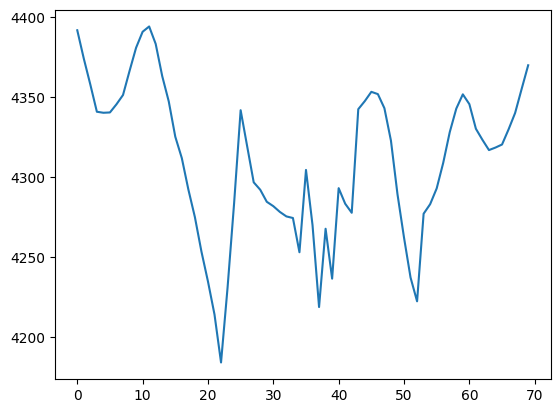

In [ ]:
# Visualize predicted values
import matplotlib.pyplot as plt
plt.plot(predicted_values)
plt.show()

In [ ]:
#Calcualte an integrated average (to account for variability) of predicted values
# to use as input for optimization
import numpy as np

# Dynamically calculate time points based on the number of predicted values
n_points = len(predicted_values)
time_points = np.linspace(0, n_points - 1, n_points)  # Evenly spaced time points

# Numerical integration using the trapezoidal rule
integral_value = np.trapz(predicted_values[:, 0], time_points)  # Access the first (and only) column of predicted_values

# Calculate the integrated average
interval_length = time_points[-1] - time_points[0]
average_capacity = integral_value / interval_length

# Print the result
print(f"Integrated average capacity: {average_capacity:.2f} kWh")

Integrated average capacity: 4309.44 kWh


## Objective function

$\text{Minimize} \; C = \sum_{m \in \text{Main}} \text{FixedCost}_m + \sum_{l \in \text{Local}} \text{FixedCost}_l + \sum_{m \in \text{Main}} \sum_{l \in \text{Local}} \text{Cost}_{m,l} \cdot \text{Vol}_{m,l} + \sum_{l \in \text{Local}} \sum_{d \in \text{Demand}} \text{Cost}_{l,d} \cdot \text{Vol}_{l,d}$


## Constraints

Capacity constraints

$\text{Vol}_{m,l} \leq \text{Cap}_{m,l}, \; \forall m \in \text{Main}, \; l \in \text{Local}$

$\text{Vol}_{l,d} \leq \text{Cap}_{l,d}, \; \forall l \in \text{Local}, \; d \in \text{Demand}$

$\text{Vol}_{\text{NuclearPlant}, s} \geq 0.7 \cdot \text{Cap}_{\text{NuclearPlant}, s}, \quad \forall s \in \text{Substations}$

Flow conservation

$\sum_{m \in \text{m}} \text{Vol}_{m,l} = \sum_{d \in \text{d}} \text{Vol}_{l,d}, \; \forall l \in \text{Local}$

$\sum_{\text{m}} \text{Vol}_{\text{m}, s} = \sum_{\text{d}} \text{Vol}_{s, \text{d}}$

Demand satisfaction

$\sum_{l \in \text{Local}} \sum_{d \in \text{Demand}} \text{Vol}_{l,d} \geq 0.9 \cdot \text{ForecastedCapacity}$

Non-negativity

$\text{Vol}_{m,l}, \; \text{Vol}_{l,d} \geq 0, \; \forall m \in \text{Main}, \; l \in \text{Local}, \; d \in \text{Demand}$

In [ ]:
import pyomo.environ as pyo

# Forecasted Capacity (scaled for nationwide demand)
forecasted_capacity = average_capacity
print(f"Using forecasted energy capacity: {forecasted_capacity:.2f} kWh")

# Parameters
plants = ['Nuclear_Plant', 'Hydro_Dam']
substations = ['Substation_A', 'Substation_B']
demand_points = ['City_1', 'City_2', 'City_3']

# Simulating costs
fixed_cost_plants = {'Nuclear_Plant': 1000, 'Hydro_Dam': 800}
fixed_cost_substations = {'Substation_A': 400, 'Substation_B': 300}

# Simulating transport costs from Nuclear and Hydro Plant to substations
cost_plant_substation = {('Nuclear_Plant', 'Substation_A'): 0.2, ('Nuclear_Plant', 'Substation_B'): 0.3,
                         ('Hydro_Dam', 'Substation_A'): 0.4, ('Hydro_Dam', 'Substation_B'): 0.5}
cost_substation_city = {('Substation_A', 'City_1'): 0.3, ('Substation_A', 'City_2'): 0.4, ('Substation_A', 'City_3'): 0.5,
                        ('Substation_B', 'City_1'): 0.5, ('Substation_B', 'City_2'): 0.6, ('Substation_B', 'City_3'): 0.4}

# Simulating Capacities
capacity_plant_substation = {('Nuclear_Plant', 'Substation_A'): forecasted_capacity * 0.7,
                             ('Nuclear_Plant', 'Substation_B'): forecasted_capacity * 0.4,
                             ('Hydro_Dam', 'Substation_A'): forecasted_capacity * 0.3,
                             ('Hydro_Dam', 'Substation_B'): forecasted_capacity * 0.2}
capacity_substation_city = {('Substation_A', 'City_1'): forecasted_capacity * 0.3,
                            ('Substation_A', 'City_2'): forecasted_capacity * 0.25,
                            ('Substation_A', 'City_3'): forecasted_capacity * 0.2,
                            ('Substation_B', 'City_1'): forecasted_capacity * 0.35,
                            ('Substation_B', 'City_2'): forecasted_capacity * 0.3,
                            ('Substation_B', 'City_3'): forecasted_capacity * 0.15}

# Pyomo Model
model = pyo.ConcreteModel()

# Decision Variables
model.vol_plant_substation = pyo.Var(plants, substations, domain=pyo.NonNegativeReals, initialize=0.1)
model.vol_substation_city = pyo.Var(substations, demand_points, domain=pyo.NonNegativeReals, initialize=0.1)

# Objective Function
model.cost = pyo.Objective(
    expr=sum(fixed_cost_plants[p] for p in plants) +
         sum(fixed_cost_substations[s] for s in substations) +
         sum(cost_plant_substation[p, s] * model.vol_plant_substation[p, s] for p in plants for s in substations) +
         sum(cost_substation_city[s, d] * model.vol_substation_city[s, d] for s in substations for d in demand_points),
    sense=pyo.minimize
)

# Constraints
def capacity_plant_substation_rule(model, p, s):
    return model.vol_plant_substation[p, s] <= capacity_plant_substation[p, s]
model.capacity_plant_substation = pyo.Constraint(plants, substations, rule=capacity_plant_substation_rule)

def capacity_substation_city_rule(model, s, d):
    return model.vol_substation_city[s, d] <= capacity_substation_city[s, d]
model.capacity_substation_city = pyo.Constraint(substations, demand_points, rule=capacity_substation_city_rule)

# Demand Satisfaction
model.demand_constraint = pyo.Constraint(
    expr=sum(model.vol_substation_city[s, d] for s in substations for d in demand_points) >= forecasted_capacity * 0.9
)

# Nuclear Plant Supply Constraints
def nuclear_supply_constraint_rule(model, s):
    return model.vol_plant_substation['Nuclear_Plant', s] >= min(capacity_plant_substation['Nuclear_Plant',s],capacity_plant_substation['Nuclear_Plant',s]*0.7)
model.nuclear_supply_positive = pyo.Constraint(substations, rule=nuclear_supply_constraint_rule)

def nuclear_capacity_constraint_rule(model, s):
    return model.vol_plant_substation['Nuclear_Plant', s] <= capacity_plant_substation['Nuclear_Plant', s]
model.nuclear_capacity_limit = pyo.Constraint(substations, rule=nuclear_capacity_constraint_rule)

def flow_conservation_rule(model, s):
    return sum(model.vol_plant_substation[p, s] for p in plants) == sum(model.vol_substation_city[s, d] for d in demand_points)
model.flow_conservation = pyo.Constraint(substations, rule=flow_conservation_rule)

# Solve the model
solver = pyo.SolverFactory('cbc')
results = solver.solve(model)

# Results
print("\nSolver Status:", results.solver.status)
print("Termination Condition:", results.solver.termination_condition)

if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("\nOptimal Cost (€):", pyo.value(model.cost))
    for p in plants:
        for s in substations:
            print(f"Flow from {p} to {s}: {pyo.value(model.vol_plant_substation[p, s]):.2f} kWh")
    for s in substations:
        for d in demand_points:
            print(f"Flow from {s} to {d}: {pyo.value(model.vol_substation_city[s, d]):.2f} kWh")
else:
    print("No optimal solution found.")

Using forecasted energy capacity: 4309.44 kWh

Solver Status: ok
Termination Condition: optimal

Optimal Cost (€): 4904.6664
Flow from Nuclear_Plant to Substation_A: 2671.85 kWh
Flow from Nuclear_Plant to Substation_B: 1206.64 kWh
Flow from Hydro_Dam to Substation_A: 0.00 kWh
Flow from Hydro_Dam to Substation_B: 0.00 kWh
Flow from Substation_A to City_1: 1292.83 kWh
Flow from Substation_A to City_2: 1077.36 kWh
Flow from Substation_A to City_3: 301.66 kWh
Flow from Substation_B to City_1: 560.23 kWh
Flow from Substation_B to City_2: 0.00 kWh
Flow from Substation_B to City_3: 646.42 kWh
